In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading and initial look

In [2]:
transactions_df = pd.read_csv("credit_card_transactions-ibm_v2.csv")

In [3]:
transactions_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [4]:
transactions_df.tail()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386899,1999,1,2020,2,28,23:10,$45.13,Chip Transaction,4751695835751691036,Merrimack,NH,3054.0,5814,NaN,No


In [5]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


Based on the outputs from head and info from *transactions_df*, at first glance there is no evidence that there are missing values for many columns, except for **Errors ?** column. Nevertheless, if after the exploratory analysis we find some missing values, we should impute them before feeding the data to the Machine Learning model.

# Exploratory Data Analysis

For the initial EDA, I would like to identify potential useful features to predict if a transaction is fraudulent or no.
This "useful" features selection is based on:
- **Intuition**: aplication of common sense
- **Experience**: previous projects in which I have worked for classificatio problems
- **Facts**: whatever insight we can get from the EDA which can support / deny my intuition and experience.

And by "useful" initial features, they would classify as such if they:
- are numerical features;
- are categorical, but with not too much levels (for practical purposes);
- have potential to be good predictors, either by correlation / discrimination properties.

First I'll explore the categorical features, and then we'll check the numerical features.

## Is Fraud? (target)
First let's explore the target variable **Is Fraud?**. From the Distribution we can see there is an extreme imbalance in the classes: 99.9% (No) vs 0.1% (Yes). Usually when the positive class represents less than 10% of the distribution, the problem can be classified as *Anomaly detection*. It also makes sense for this case, as fraudulent transactions are usually anomalies, exceptions which should have some strange behavior.
Ideally, we should apply some sampling technique to have a balanced distribution for the target before training the model. If we don't do that, the model will just try to predict that everything is not fraud to optimize the accuracy, which in baseline is 99.9%. Some options we have are:
- *Downsampling*: this would result into a big loss of information, as we'll only be working with 0.2% of the data.
- *Upsampling*: this would be the usual case, but in this case might introduce too many redundant instances.

For an initial balancing technique, we can use a Random Forest with weights for the classes, so that for each tree the samples are taken to balance the distribution. 
For a more advanced, approach, and based on my experience with Anomaly detection and Ensemble methods, I would like to apply *Blagging* technique.

     Is Fraud?
No     0.99878
Yes    0.00122


<AxesSubplot:>

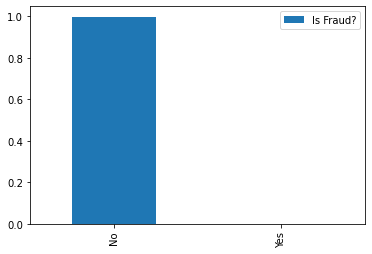

In [6]:
target = transactions_df['Is Fraud?']
target_percents = pd.DataFrame(target.value_counts() / target.shape[0])
print(target_percents)
target_percents.plot.bar(y='Is Fraud?')

For practical purposes of the analysis and model building, we'll encode the target as a binary feature:
- "Yes" 1
- "No": 0

In [7]:
transactions_df['Is Fraud?'] = (transactions_df['Is Fraud?'] == 'Yes').astype(int)

## Use Chip
The **Use Chip** feature seems to have potential. It only has three levels: Chip, Online, and Swipe Transaction.
In addition, it seems to be a discriminator by itself for the target. Notice how Online Transaction has a higher chance to be a fraudulent transaction, as around 85% of those were Online transactions, while fraudulent Chip Transactions it's relatively low around 10%. Fraudulent transactions with Swipe are around 5%.
This was interesting to me, as I thought that the chip makes harder for fraud to occur, but it looks like actually there is higher chance for fraud (10% for chip vs 5% for swipe).

In [8]:
transactions_df['Use Chip'].value_counts()

Swipe Transaction     15386082
Chip Transaction       6287598
Online Transaction     2713220
Name: Use Chip, dtype: int64

In [9]:
def check_potential(feature_name, target='Is Fraud?', df=transactions_df):
    feature_percents = df.loc[:, [feature_name, target]]. \
        groupby(feature_name). \
        aggregate(np.mean)
    feature_percents.plot.bar()
    return feature_percents

,Is Fraud?
Use Chip,
Chip Transaction,0.096636
Online Transaction,0.849697
Swipe Transaction,0.053667


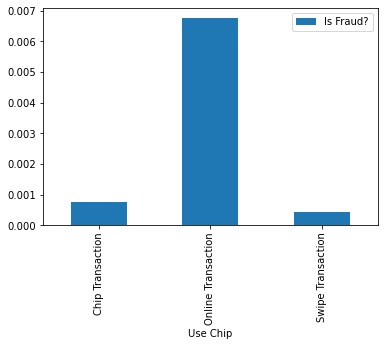

In [10]:
use_chip_percents = check_potential('Use Chip')
use_chip_percents / sum(use_chip_percents['Is Fraud?'])

## Errors?
I thought **Errors?** would have less levels, but as it is now with 23 levels seems too high to be included in a base model.

In [11]:
transactions_df['Errors?'].value_counts()

Insufficient Balance                                   242783
Bad PIN                                                 58918
Technical Glitch                                        48157
Bad Card Number                                         13321
Bad CVV                                                 10740
Bad Expiration                                          10716
Bad Zipcode                                              2079
Bad PIN,Insufficient Balance                              581
Insufficient Balance,Technical Glitch                     457
Bad PIN,Technical Glitch                                  128
Bad Card Number,Insufficient Balance                      122
Bad CVV,Insufficient Balance                               89
Bad Expiration,Insufficient Balance                        78
Bad Card Number,Bad CVV                                    60
Bad Card Number,Bad Expiration                             54
Bad Expiration,Bad CVV                                     47
Bad Expi

Nevertheless, if we see the cumulative percentage, notice how the top 6 errors cover around 99% of the cases.
Therefore, we can consider these as the most important levels, and tag the rest as *Other* error. This would give us 7 levels instead of 23. These information will be encoded in a new feature "errors_group", which might be more useful than the original one.

In [12]:
errors_counts = transactions_df['Errors?'].value_counts()
errors_percents = errors_counts / sum(errors_counts)
print(errors_percents)
top_errors_totals = sum(errors_percents[:6])
print(f"\nTop 5 errors total: {top_errors_totals}")

Insufficient Balance                                   0.625035
Bad PIN                                                0.151682
Technical Glitch                                       0.123978
Bad Card Number                                        0.034294
Bad CVV                                                0.027650
Bad Expiration                                         0.027588
Bad Zipcode                                            0.005352
Bad PIN,Insufficient Balance                           0.001496
Insufficient Balance,Technical Glitch                  0.001177
Bad PIN,Technical Glitch                               0.000330
Bad Card Number,Insufficient Balance                   0.000314
Bad CVV,Insufficient Balance                           0.000229
Bad Expiration,Insufficient Balance                    0.000201
Bad Card Number,Bad CVV                                0.000154
Bad Card Number,Bad Expiration                         0.000139
Bad Expiration,Bad CVV                  

In [13]:
def label_error(error_value):
    if error_value is np.nan:
        return 'No Error'
    if error_value == 'Insufficient Balance':
        return 'Insufficient Balance'
    if error_value == 'Bad PIN':
        return 'Bad PIN'
    if error_value == 'Technical Glitch':
        return 'Technical Glitch'
    if error_value == 'Bad Card Number':
        return 'Bad Card Number'
    if error_value == 'Bad CVV':
        return 'Bad CVV'
    if error_value == 'Bad Expiration':
        return 'Bad Expiration'
    return 'Other'

In [14]:
transactions_df['errors_group'] = transactions_df.loc[:, 'Errors?'].apply(label_error)

,Is Fraud?
errors_group,
Bad CVV,0.026071
Bad Card Number,0.007882
Bad Expiration,0.011198
Bad PIN,0.005126
Insufficient Balance,0.001631
No Error,0.001186
Other,0.005269
Technical Glitch,0.001308


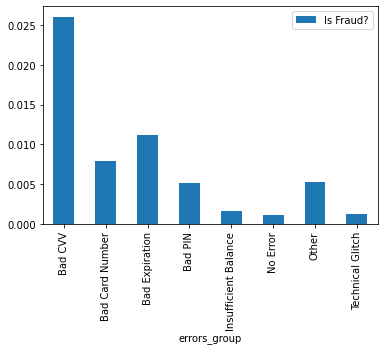

In [15]:
check_potential('errors_group')

It's interesting to see how Bad CVV has the higher chance of being a fraudulent transaction (around 2.5%). Bad Expiration also has a smal chance of around 1%. And Bad Card Number and Bad PIN are the next two with almost 0.5% of probability.
What is interesting to observe, is that there are some fraudulent cases in which at least one of the properties of the credit card is unknown.

## Amount
For the **Amount** feature, first we'll do an appropriate parsing to float. In addition, we'll apply a capping by IQR to remove outliers (for plotting purposes).

In [16]:
def curr_to_float(currency):
    return float(currency.replace('$', ''))

transactions_df['Amount'] = transactions_df['Amount'].apply(curr_to_float)

In [17]:
def cap_by_IQR(feature):
    """Apply and IQR for capping the low and high limits, to remove outliers.
    """
    temp_df = pd.DataFrame({'temp_feature': feature})
    Q1 = temp_df['temp_feature'].quantile(0.25)
    Q3 = temp_df['temp_feature'].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - 1.5 * IQR
    high_limit = Q3 + 1.5 * IQR
    temp_df.loc[temp_df.temp_feature < low_limit, 'temp_feature'] = low_limit
    temp_df.loc[temp_df.temp_feature > high_limit, 'temp_feature'] = high_limit
    return temp_df.temp_feature

transactions_df['Amount_capped'] = cap_by_IQR(transactions_df['Amount'])

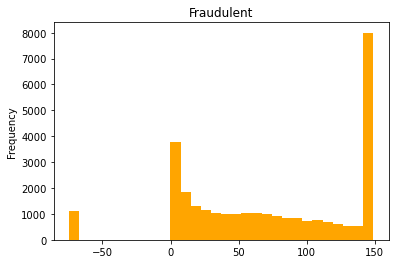

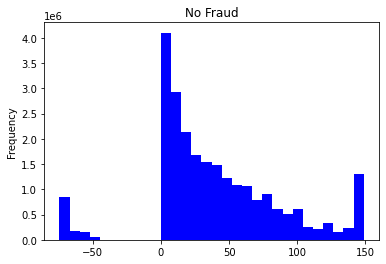

In [18]:
transactions_df.loc[transactions_df['Is Fraud?'] == 1, 'Amount_capped'].plot.hist(bins=30, title='Fraudulent', color='orange')
plt.show()
transactions_df.loc[transactions_df['Is Fraud?'] == 0, 'Amount_capped'].plot.hist(bins=30, title='No Fraud', color='blue')
plt.show()

This feature seems to have some discrimination potential, as transaction which are fraudulent seem to be biased toward higher values than normal transactions. Maybe an indicator that the ones who commit fraud try to get as much as possible?
Also, we can see that the average amount for fraudulent transactions is much higher than for normal ones: 109 vs 44 USD.
By performing a  Welch’s t-test for the difference in means, we can see that there is enough evidence to reject the null hypothesis of equal population means (p-value < 0.05)

,Amount
Is Fraud?,
0,43.554648
1,108.590874


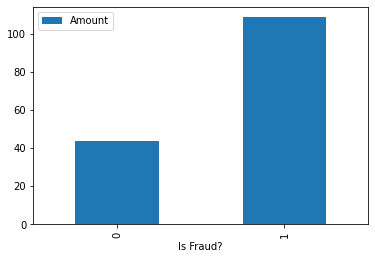

In [19]:
check_potential('Is Fraud?', 'Amount')

In [20]:
from scipy import stats

normal_amount = transactions_df.loc[transactions_df['Is Fraud?'] == 0, 'Amount']
fraudulent_amount = transactions_df.loc[transactions_df['Is Fraud?'] == 1, 'Amount']
stats.ttest_ind(fraudulent_amount.sample(10000), normal_amount.sample(10000), equal_var=False)

Ttest_indResult(statistic=29.61744932636242, pvalue=1.2875584230157716e-186)

## Time (hour)
For the **time** feature, first we'll do an appropriate parsing to float. We'll just extract the hour part from it, and store it into a new feature **hour**.
Notice how the transactions which are fraudulent have a varying patten across the hour of the day. With two peaks in the early morning (3am to 5am) and around the midday. After midday it begins to decrease, until it drops at 8pm until the midnight.
This varying distribution allow us to think that the **hour** feature can be useful to identify a fraudulent transaction.

In [21]:
def parse_time(time_str):
    return int(time_str.split(':')[0])
    
transactions_df['hour'] = transactions_df.loc[:, 'Time'].apply(parse_time)

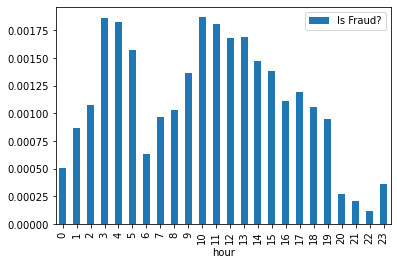

In [22]:
hour_percents = check_potential('hour')

## Month
Like **hour**, I thought that **Month** feature could also be an indicator of fraud, as some months have some special events like Easter, Christmas, Thanksgiving... which might make more attractive to have fraud.
While there seems to be a patterns across the months, there is just a slight variation. With some interesting peaks at March, August, and the last three months.

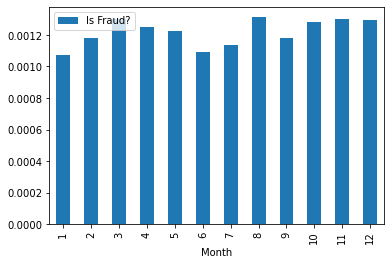

In [23]:
month_percents = check_potential('Month')

## Day
**Day** feature seems to show a similar pattern as with Month, just a slight variation but with some interesting peaks at some days, like 12 and close to 20. We see how on the first few days and the last days of the month there seem to be an increase in fraudulent transactions. Maybe, as these days are close to paydays, it might make more attractive to commit fraud.

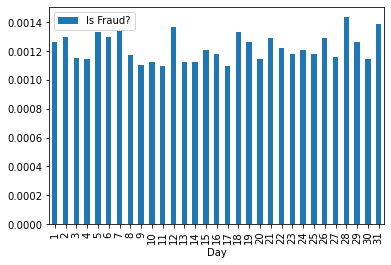

In [24]:
day_percents = check_potential('Day')

## Merchant-based features
Most **merchant-based** columns have too many unique values as to be included in a base model:
- **Merchant Name** has around 100K unique values
- **Merchant City** has around 13K unique values
- **Merchant State** has 223 unique values
- **Zip** has around 27K unique values
- **MCC** has 109 unique values

In [25]:
name_counts = transactions_df['Merchant Name'].value_counts()
print(f'Total Merchant Names: {len(name_counts)}')
name_percents = name_counts / sum(name_counts) * 100
print(f'Relevant names: {sum(name_percents > 0.01)}')

Total Merchant Names: 100343
Relevant names: 541


In [26]:
city_counts = transactions_df['Merchant City'].value_counts()
print(f'Total Merchant Cities: {len(city_counts)}')
city_percents = city_counts / sum(city_counts) * 100
print(f'Relevant cities: {sum(city_percents > 0.1)}')

Total Merchant Cities: 13429
Relevant cities: 171


In [50]:
state_counts = transactions_df['Merchant State'].value_counts()
print(f'Total Merchant States: {len(state_counts)}')
state_percents = state_counts / sum(state_counts) * 100
print(f'Relevant States: {sum(state_percents > 0.5)}')
sum(state_percents[:40])
print(f'Cummulative percent:', sum(state_percents[:40]))

Total Merchant States: 223
Relevant States: 40
Cummulative percent: 96.44716517464931


In [28]:
zip_counts = transactions_df['Zip'].value_counts()
print(f'Total Zip codes: {len(zip_counts)}')
zip_percents = zip_counts / sum(zip_counts) * 100
print(f'Relevant Zip codes: {sum(zip_percents > 0.1)}')

Total Zip codes: 27321
Relevant Zip codes: 86


In [51]:
mcc_counts = transactions_df['MCC'].value_counts()
print(f'Total MCC codes: {len(mcc_counts)}')
mcc_percents = mcc_counts / sum(mcc_counts) * 100
print(f'Relevant MCC codes: {sum(mcc_percents > 0.2)}')
print(f'Cummulative percent:', sum(mcc_percents[:40]))

Total MCC codes: 109
Relevant MCC codes: 38
Cummulative percent: 96.3110604463872


**MCC** is a feature which would be interesting to add, as it denotes the type of business providing a service or selling merchandise. In addition, MCCs are used by card issuers to categorize, track or restrict certain types of purchases.
Therefore, some MCCs might appear more often on fraudulent transactions.

To include it as a feature, we'll consider the top 40 as relevant MCC codes, which represent around 96% of the cases. And classify the rest as others.
We'll do something similar for the **Merchant State** feature, as also the top 40 represent around 96% of the cases.

In [30]:
top_40_states = state_percents.index[:40]
def label_state(state):
    if state in top_40_states:
        return state
    return 'Other'

transactions_df['merchant_state_group'] = transactions_df.loc[:, 'Merchant State'].apply(label_state)

In [142]:
states_fraud = transactions_df.loc[:, ['Merchant State', 'Is Fraud?']]. \
        groupby('Merchant State'). \
        aggregate(['mean', 'count'])

states_fraud['percent'] = states_fraud['Is Fraud?']['count'] / states_fraud['Is Fraud?']['count'].sum()
states_fraud['score'] = states_fraud['Is Fraud?']['mean'] * states_fraud['percent']
states_fraud['score'] = states_fraud['score'] / states_fraud['score'].sum()
states_fraud.sort_values(by='score', ascending=False, inplace=True)
print('\nCummulative score: {:.2f}'.format(states_fraud[:20]["score"].sum()))
states_fraud[:20]


Cummulative score: 0.88


Is Fraud?            percent     score
                    mean    count                    
Merchant State                                       
Italy           0.536312     8730  0.000403  0.410414
OH              0.000980   895970  0.041354  0.076964
CA              0.000290  2591830  0.119626  0.065831
Algeria         0.961774      654  0.000030  0.055137
Haiti           0.840807      446  0.000021  0.032872
FL              0.000215  1458699  0.067326  0.027525
TX              0.000170  1793298  0.082770  0.026736
Mexico          0.005769    47152  0.002176  0.023843
Turkey          0.544492      472  0.000022  0.022528
NY              0.000166  1446864  0.066780  0.021038
NJ              0.000271   630317  0.029092  0.014989
MI              0.000259   618407  0.028543  0.014025
NC              0.000185   779234  0.035966  0.012623
PA              0.000172   839647  0.038754  0.012623
Nigeria         0.613734      233  0.000011  0.012535
IL              0.000134   850074  0.039235  0.009993
TN              0.000216   504116  0.023268  0.009555
WA              0.000199   537762  0.024820  0.009379
VA              0.000247   425216  0.019626  0.009204
IN              0.000171   613432  0.028313  0.009204

For the states, it is of interest to identify the ones in which fraud is an issue, either because there is a high percent of fraudulent cases on that state, or because there is a high number of transactions in that state. To take both factors into consideration, we'll calculate a score as:

$score = percent(fraudulentCases) * percent(totalCases)$

Then we normalize the score column, and sort by it to identify the states with most fraudulent issues.
We present the top 20 states, which make up around 88% of the total score.
We can see three kind of states:
- States with high percent of fraudulent cases: like Italy (54%), Algeria (96%), Turkey (54%), Nigeria (61%)...
- States with high percent of total cases: like CA (12%), FL (7%), TX (8%), NY (7%)...
- States with low percent of fraudulent cases but high percent of total cases (high score): like OH (8% score), Mexico (2%), IL (1%)...

In [91]:
mcc_codes_df = pd.read_csv('mcc_codes.csv')
mcc_codes_df.head()

,mcc,edited_description,combined_description,usda_description,irs_description,irs_reportable
0,742,Veterinary Services,Veterinary Services,Veterinary Services,Veterinary Services,Yes
1,763,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Cooperative,Yes
2,780,"Horticultural Services, Landscaping Services","Horticultural Services, Landscaping Services",Horticultural Services,Landscaping Services,Yes
3,1520,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors,Yes
4,1711,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,"Heating, Plumbing, A/C",Yes


In [78]:
mcc_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   mcc                   981 non-null    int64 
 1   edited_description    981 non-null    object
 2   combined_description  973 non-null    object
 3   usda_description      706 non-null    object
 4   irs_description       963 non-null    object
 5   irs_reportable        963 non-null    object
dtypes: int64(1), object(5)
memory usage: 46.1+ KB


In [33]:
top_40_mccs = mcc_percents.index[:40]
def label_mcc(mcc):
    if mcc in top_40_mccs:
        return mcc
    return 'Other'

transactions_df['mcc_group'] = transactions_df.loc[:, 'MCC'].apply(label_mcc)

In [144]:
mccs_fraud = transactions_df.loc[:, ['MCC', 'Is Fraud?']]. \
        groupby('MCC'). \
        aggregate(['mean', 'count'])
mccs_fraud['mcc'] = mccs_fraud.index
mccs_fraud.index = list(range(mccs_fraud.shape[0]))

mccs_fraud['percent'] = mccs_fraud['Is Fraud?']['count'] / mccs_fraud['Is Fraud?']['count'].sum()
mccs_fraud['score'] = mccs_fraud['Is Fraud?']['mean'] * mccs_fraud['percent']
mccs_fraud['score'] = mccs_fraud['score'] / mccs_fraud['score'].sum()
mccs_fraud.sort_values(by='score', ascending=False, inplace=True)
top_20_score = mccs_fraud.loc[:20, ('score', '')].sum()
mcc_descriptions = mcc_codes_df.loc[:, ['mcc', 'edited_description']]
mccs_fraud = pd.merge(mccs_fraud, mcc_descriptions, on='mcc')
mccs_fraud.drop('mcc', 1, inplace=True)
print("\nCummulative score: {:.2f}".format(top_20_score))
mccs_fraud.loc[:20, ]


Cummulative score: 0.95


C:\Users\romdel\.conda\envs\frank\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(Is Fraud?, mean)","(Is Fraud?, count)","(mcc, )","(percent, )","(score, )",edited_description
0,0.005446,885720,5311,0.036319,0.162113,Department Stores
1,0.001960,1123037,5300,0.046051,0.073966,Wholesale Clubs
2,0.004739,454107,5310,0.018621,0.072319,Discount Stores
3,0.001423,1129061,4829,0.046298,0.054004,Money Orders – Wire Transfer
4,0.000751,1407636,5912,0.057721,0.035521,Drug Stores and Pharmacies
5,0.000330,2860738,5411,0.117306,0.031690,"Grocery Stores, Supermarkets"
6,0.007627,115247,5815,0.004726,0.029539,"Digital Goods: Media, Books, Movies, Music"
7,0.006175,137489,5651,0.005638,0.028531,Family Clothing Stores
8,0.066942,12593,5732,0.000516,0.028329,Electronic Sales
9,0.004474,160277,5719,0.006572,0.024095,Miscellaneous Home Furnishing Specialty Stores


For the MCCs, like we did with the states, it is of interest to identify the ones in which fraud is an issue.

We present the top 20 MCCs, which make up around 95% of the total score.
We can see three kind of MCCs:
- MCCs with high percent of fraudulent cases: like Computers, Computer Peripheral Equipment, Soft... (10%); Electronic Sales (7%), Precious Stones and Metals; Furniture, Home Furnishings, and Equipment Sto... (6%); Watches and Jewelry (6%)...
- MCCs with high percent of total cases: like Grocery Stores, Supermarkets (12%), Service Stations (11%), Eating places and Restaurants (7%), Wholesale Clubs (7%)...
- MCCs with low percent of fraudulent cases but high percent of total cases (high score): like Discount Stores (2% score), Drug Discount Stores (1% score), Digital Goods: Media, Books, Movies, Music (1%)...

## Set of features from transactions_df
Now we are ready to select the potential features from the *transactions_df*.

In [34]:
features_set = transactions_df.loc[:, ['Use Chip', 'errors_group', 'Amount', 'hour', 'Month', 'Day',
                                      'merchant_state_group', 'mcc_group']]

In [35]:
features_set

,Use Chip,errors_group,Amount,hour,Month,Day,merchant_state_group,mcc_group
0,Swipe Transaction,No Error,134.09,6,9,1,CA,5300
1,Swipe Transaction,No Error,38.48,6,9,1,CA,5411
2,Swipe Transaction,No Error,120.34,6,9,2,CA,5411
3,Swipe Transaction,No Error,128.95,17,9,2,CA,5651
4,Swipe Transaction,No Error,104.71,6,9,3,CA,5912
...,...,...,...,...,...,...,...,...
24386895,Chip Transaction,No Error,-54.00,22,2,27,NH,5541
24386896,Chip Transaction,No Error,54.00,22,2,27,NH,5541
24386897,Chip Transaction,No Error,59.15,7,2,28,NH,4121
24386898,Chip Transaction,No Error,43.12,20,2,28,NH,4121


First we'll get the dummy variables for the categorical features.
There are no missing values, as we handled them on the feature engineering process.

In [36]:
features_set = pd.get_dummies(features_set)
features_set

,Amount,hour,Month,Day,Use Chip_Chip Transaction,Use Chip_Online Transaction,Use Chip_Swipe Transaction,errors_group_Bad CVV,errors_group_Bad Card Number,errors_group_Bad Expiration,...,mcc_group_7538,mcc_group_7542,mcc_group_7801,mcc_group_7832,mcc_group_7922,mcc_group_7995,mcc_group_8011,mcc_group_8021,mcc_group_9402,mcc_group_Other
0,134.09,6,9,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.48,6,9,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,120.34,6,9,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,128.95,17,9,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,104.71,6,9,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,-54.00,22,2,27,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24386896,54.00,22,2,27,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24386897,59.15,7,2,28,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24386898,43.12,20,2,28,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
target = transactions_df['Is Fraud?']
target.describe()

count    2.438690e+07
mean     1.220204e-03
std      3.491011e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: Is Fraud?, dtype: float64

# Model Building
For the model, I decided to fit a Random Forest. This will allow us to get:
- Features importance: to determine the importance of each feature to predict the fraud.
- Out-of-bag Score: to get an idea of the actual performance of the model (to be compared to test metrics).

Ideally, the hyper-parameters of the model should be optimized with some technique, like K-fold cross-validation.
But we'll choose some robuts & generic parameters for simplicity purposes. Some observations:
- using 500 estimators as a robuts number of decision trees.
- using max_depth, min_samples_split, min_samples_leaf, and max_features parameters to have weak learners.
- using max_samples = 30000 (for practical purposes)
- using class_weight='balanced' so that each sample is balanced on the target

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features_set, target, test_size=0.4, random_state=42, stratify=target)

In [40]:
max_samples = 30000

In [41]:
clf = RandomForestClassifier(n_estimators=500, max_depth=3, min_samples_split=50, min_samples_leaf=25, max_features='sqrt',
                             max_samples=max_samples, bootstrap=True, oob_score=True, n_jobs=-1, class_weight='balanced', 
                             verbose=1, random_state=500)

In [42]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


RandomForestClassifier(class_weight='balanced', max_depth=3,
                       max_features='sqrt', max_samples=30000,
                       min_samples_leaf=25, min_samples_split=50,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=500, verbose=1)

In [43]:
y_pred = clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.7min finished


# Evaluation Metrics
From the classification report, we can see how most of the metrics seem to be around 88% in average.
The Out-of-bag score we get from the random forest classifier is also very close to 88%. This is a good indicator that the model did not overfit or underfit.
In addition, the weighted avg for precision, recall, and thus F1-score are also close to 88%.

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.88      0.94   9742857
           1       0.01      0.77      0.02     11903

    accuracy                           0.88   9754760
   macro avg       0.50      0.82      0.48   9754760
weighted avg       1.00      0.88      0.94   9754760



In [146]:
print("Out-of-bag score: {:.2f}".format(clf.oob_score_))

Out-of-bag score: 0.88


## Confusion Matrix
Something we can notice on the confusion Matrix, is that the model doesn't seem to have a specific bias to any of the classes. Nevertheless, the recall on the positive label could be increased to be also above 80%, by fine-tuning the model. This will increase number of True-Positive cases and reduce number of False-Positive cases (currently 12% of normal transactions are classified as fraudulent).

A good property we can observe, is that given the high recall (around 77% on positive class) it means that the model is able to capture most of the fraudulent transactions.

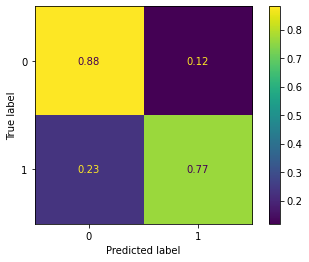

In [46]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Features Importance
We have 97 features in total. From the random_forest, we can get the importances of the features based on information gain.
As can be seen, the top 20 most important features are:
- merchant_state_group_Other     
- Use Chip_Online Transaction
- Use Chip_Swipe Transaction
- Amount                         
- mcc_group_Other                
- hour                                                       
- mcc_group_5311                                    
- mcc_group_5541                 
- mcc_group_5499                                                
- Day                            
- mcc_group_5411  
- merchant_state_group_TX 
- Month                          
- mcc_group_4784      
- merchant_state_group_CA  
- Use Chip_Chip Transaction
- mcc_group_5310                 
- merchant_state_group_FL
- merchant_state_group_NY  
- mcc_group_5812                 

These 20 features by themselves make up around 92% of the cummulative importance.
In addition, we could use these importances to remove unimportant features. 
Around 52 features have importance which is technically zero (less than 0.1%). 
By removing these, and refitting the model, we might compare how the performance is impacted.

It is interesting to see the Merchant State which seem important. *Other* being the most important feature might be an indicator that when transactions are not in the most common states, that it is a fraudulent one (anomaly):
- Other
- TX
- CA
- FL
- NY

Another interesting aspect from features importance, is to see the descriptions for this important mccs:
- 5311: Department Stores
- 5541: Service Stations
- 5499: Misc. Food Stores – Convenience Stores and Specialty Markets
- 5411: Grocery Stores, Supermarkets
- 4784: Toll and Bridge Fees
- 5310: Discount Stores
- 5812: Eating places and Restaurants

Most of these were already identified from our previous analysis. However, these two were not part of the top 20, but ended up being important: 
- 5499: Misc. Food Stores – Convenience Stores and Specialty Markets
- 4784: Toll and Bridge Fees

In [147]:
forest_importances = pd.Series(clf.feature_importances_, index=features_set.columns)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances[:20]

merchant_state_group_Other     0.192244
Use Chip_Online Transaction    0.145591
Use Chip_Swipe Transaction     0.107783
Amount                         0.098725
mcc_group_Other                0.087334
hour                           0.049662
mcc_group_5311                 0.031804
mcc_group_5541                 0.022936
mcc_group_5499                 0.022693
Day                            0.020812
mcc_group_5411                 0.020566
merchant_state_group_TX        0.018826
Month                          0.016790
mcc_group_4784                 0.015744
merchant_state_group_CA        0.015725
Use Chip_Chip Transaction      0.014976
mcc_group_5310                 0.011351
merchant_state_group_FL        0.010636
merchant_state_group_NY        0.010240
mcc_group_5812                 0.008677
dtype: float64

In [48]:
print(f"Cummulative importance for top 20 features: {forest_importances[:20].sum()}")

Cummulative importance for top 20 features: 0.9231144870995655


In [49]:
print(f"Number of unimportant features: {(forest_importances < 0.001).sum()}")

Number of unimportant features: 52
